# Лабораторная работа 5
## Градиентный бустинг
### Многие блоки уже повторяются, и некоторые подблоки я уже объединяю в один.

В этом блоке я подключаю все нужные библиотеки которые использую в лабораторной работе

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report,
    mean_absolute_error, mean_squared_error, r2_score
)
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor

sns.set(style="whitegrid")

## SPAM SMS

Загружаю датасет со спам сообщениями и разделяю сообщения на признаки и метки, а затем делю данные на обучающую и тестовую выборки

In [ ]:
spam_path = "/content/spam.csv"

spam_df = pd.read_csv(spam_path, encoding="latin1")[["v1", "v2"]]
spam_df.columns = ["label", "message"]

print("Размер датасета:", spam_df.shape)
print(spam_df["label"].value_counts())

X = spam_df["message"]
y = spam_df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("\nОбучающая выборка:", len(X_train))
print("Тестовая выборка :", len(X_test))

Размер датасета: (5572, 2)
label
ham     4825
spam     747
Name: count, dtype: int64

Обучающая выборка: 4457
Тестовая выборка : 1115


Здесь я создаю базовую модель градиентного бустинга для задачи со спамом. Создаю пайплайн как обычно: tf-idf - текст в числа, а GradientBoostingClassifier делит на spam и ham.

Обучаю модель на тренировочных данных, предсказываю на тесте и считаю метрики качества, вывожу отчет по классам и строю матрицу ошибок.


=== Базовый Gradient Boosting (спам) ===
Accuracy : 0.9614
Precision: 0.9907
Recall   : 0.7181
F1 (spam): 0.8327

              precision    recall  f1-score   support

         ham       0.96      1.00      0.98       966
        spam       0.99      0.72      0.83       149

    accuracy                           0.96      1115
   macro avg       0.97      0.86      0.91      1115
weighted avg       0.96      0.96      0.96      1115



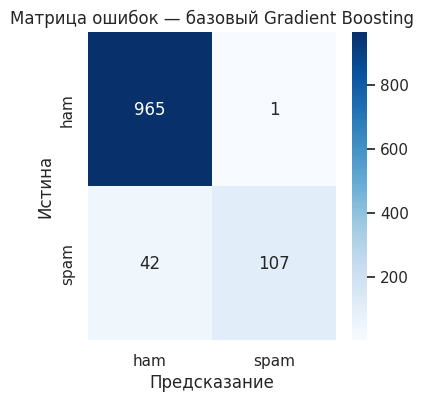

In [ ]:
gb_clf_base = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words="english")),
    ("gb", GradientBoostingClassifier(random_state=42))
])

gb_clf_base.fit(X_train, y_train)
y_pred_base = gb_clf_base.predict(X_test)

acc_base = accuracy_score(y_test, y_pred_base)
prec_base = precision_score(y_test, y_pred_base, pos_label="spam")
rec_base = recall_score(y_test, y_pred_base, pos_label="spam")
f1_base = f1_score(y_test, y_pred_base, pos_label="spam")

print("\n=== Базовый Gradient Boosting (спам) ===")
print(f"Accuracy : {acc_base:.4f}")
print(f"Precision: {prec_base:.4f}")
print(f"Recall   : {rec_base:.4f}")
print(f"F1 (spam): {f1_base:.4f}\n")
print(classification_report(y_test, y_pred_base))

cm_base = confusion_matrix(y_test, y_pred_base, labels=["ham", "spam"])
plt.figure(figsize=(4, 4))
sns.heatmap(cm_base, annot=True, fmt="d", cmap="Blues",
            xticklabels=["ham", "spam"], yticklabels=["ham", "spam"])
plt.xlabel("Предсказание")
plt.ylabel("Истина")
plt.title("Матрица ошибок — базовый Gradient Boosting")
plt.show()

### Гипотезы как можно улучшить модели:

- уменьшить learning_rate и увеличить число деревьев для более плавного обучения

- использовать неглубокие деревья как базовые модели

- применять subsample для снижения переобучения

- подобрать параметры бустинга с помощью кросс-валидации


В этом блоке я настраиваю градиентный бустинг.
Для этого создаю пайплайн с TF-IDF и самим бустингом, а затем задаю сетку параметров, где перебираются разные варианты.

GridSearchCV автоматически перебирает все комбинации и выбирает те, которые дают лучший F1-score.
После этого я беру лучшую модель, делаю предсказания и считаю метрики.

Дальше опять строю матрицу ошибок и вывожу таблицу сравнения.

Fitting 3 folds for each of 32 candidates, totalling 96 fits

Лучшие параметры (классификация):
{'gb__learning_rate': 0.1, 'gb__max_depth': 3, 'gb__n_estimators': 100, 'tfidf__min_df': 3, 'tfidf__ngram_range': (1, 1)}
Лучший F1 (cv): 0.9035462232783645

=== Улучшенный Gradient Boosting (спам) ===
Accuracy : 0.9623
Precision: 0.9820
Recall   : 0.7315
F1 (spam): 0.8385

              precision    recall  f1-score   support

         ham       0.96      1.00      0.98       966
        spam       0.98      0.73      0.84       149

    accuracy                           0.96      1115
   macro avg       0.97      0.86      0.91      1115
weighted avg       0.96      0.96      0.96      1115



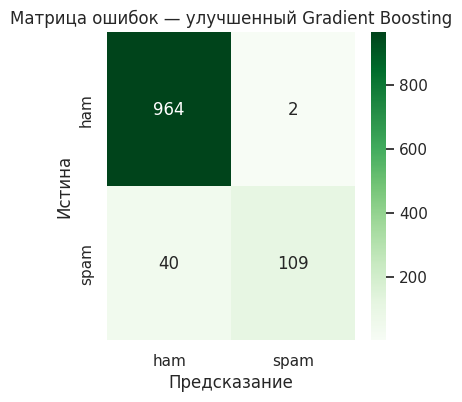


Сравнение моделей (классификация):


,model,accuracy,precision_spam,recall_spam,f1_spam
0,baseline,0.961435,0.990741,0.718121,0.832685
1,improved,0.962332,0.981982,0.731544,0.838462


In [ ]:
pipe_clf = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words="english")),
    ("gb", GradientBoostingClassifier(random_state=42))
])

param_grid_clf = {
    "tfidf__ngram_range": [(1, 1), (1, 2)],
    "tfidf__min_df": [1, 3],
    "gb__n_estimators": [50, 100],
    "gb__learning_rate": [0.05, 0.1],
    "gb__max_depth": [2, 3]
}

grid_clf = GridSearchCV(
    pipe_clf,
    param_grid_clf,
    cv=3,
    scoring="f1_macro",
    n_jobs=-1,
    verbose=1
)

grid_clf.fit(X_train, y_train)

print("\nЛучшие параметры (классификация):")
print(grid_clf.best_params_)
print("Лучший F1 (cv):", grid_clf.best_score_)

best_gb_clf = grid_clf.best_estimator_
y_pred_best = best_gb_clf.predict(X_test)

acc_best = accuracy_score(y_test, y_pred_best)
prec_best = precision_score(y_test, y_pred_best, pos_label="spam")
rec_best = recall_score(y_test, y_pred_best, pos_label="spam")
f1_best = f1_score(y_test, y_pred_best, pos_label="spam")

print("\n=== Улучшенный Gradient Boosting (спам) ===")
print(f"Accuracy : {acc_best:.4f}")
print(f"Precision: {prec_best:.4f}")
print(f"Recall   : {rec_best:.4f}")
print(f"F1 (spam): {f1_best:.4f}\n")
print(classification_report(y_test, y_pred_best))

cm_best = confusion_matrix(y_test, y_pred_best, labels=["ham", "spam"])
plt.figure(figsize=(4, 4))
sns.heatmap(cm_best, annot=True, fmt="d", cmap="Greens",
            xticklabels=["ham", "spam"], yticklabels=["ham", "spam"])
plt.xlabel("Предсказание")
plt.ylabel("Истина")
plt.title("Матрица ошибок — улучшенный Gradient Boosting")
plt.show()

comp_clf = pd.DataFrame({
    "model": ["baseline", "improved"],
    "accuracy": [acc_base, acc_best],
    "precision_spam": [prec_base, prec_best],
    "recall_spam": [rec_base, rec_best],
    "f1_spam": [f1_base, f1_best]
})
print("\nСравнение моделей (классификация):")
display(comp_clf)


## Рейтинг фильмов

загружаю таблицу с рейтингами и таблицу с информацией о фильмах. Чтобы ускорить работу беру только 50 тысяч оценок. Потом объединяю две таблицы по movieId чтобы у каждой оценки появились данные о самом фильме

Сначала с помощью регулярного выражения я вытаскиваю год из названия фильма. Если года нет то строка удаляется. Затем я превращаю строку с жанрами в список жанров и кодирую их в набор бинарных признаков через multilabelbinizer

In [ ]:
ratings_path = "/content/rating.csv"
movies_path = "/content/movie.csv"

ratings_df = pd.read_csv(ratings_path, nrows=50000)
movies_df = pd.read_csv(movies_path)

print("\nРазмер ratings:", ratings_df.shape)
print("Размер movies :", movies_df.shape)

data_ml = ratings_df.merge(movies_df, on="movieId", how="left")
print("Размер объединённой таблицы:", data_ml.shape)
display(data_ml.head())

import re

def extract_year(title):
    m = re.search(r"(19\d{2}|20\d{2})", str(title))
    return int(m.group(0)) if m else np.nan

data_ml["year"] = data_ml["title"].apply(extract_year)
data_ml = data_ml.dropna(subset=["year"])

data_ml["genres_list"] = data_ml["genres"].fillna("(no genres listed)").apply(
    lambda s: s.split("|")
)

mlb = MultiLabelBinarizer()
genres_encoded = mlb.fit_transform(data_ml["genres_list"])
genres_df = pd.DataFrame(genres_encoded, columns=[f"genre_{g}" for g in mlb.classes_])

features_ml = pd.concat(
    [data_ml[["rating", "year"]].reset_index(drop=True),
     genres_df.reset_index(drop=True)],
    axis=1
)

print("\nРазмер таблицы признаков:", features_ml.shape)
display(features_ml.head())

X_reg = features_ml.drop(columns=["rating"])
y_reg = features_ml["rating"]

X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

print("\nРегрессия train:", X_reg_train.shape)
print("Регрессия test :", X_reg_test.shape)


Размер ratings: (50000, 4)
Размер movies : (27278, 3)
Размер объединённой таблицы: (50000, 6)


,userId,movieId,rating,timestamp,title,genres
0,1,2,3.5,2005-04-02 23:53:47,Jumanji (1995),Adventure|Children|Fantasy
1,1,29,3.5,2005-04-02 23:31:16,"City of Lost Children, The (Cité des enfants p...",Adventure|Drama|Fantasy|Mystery|Sci-Fi
2,1,32,3.5,2005-04-02 23:33:39,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller
3,1,47,3.5,2005-04-02 23:32:07,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,3.5,2005-04-02 23:29:40,"Usual Suspects, The (1995)",Crime|Mystery|Thriller



Размер таблицы признаков: (50000, 21)


,rating,year,genre_Action,genre_Adventure,genre_Animation,genre_Children,genre_Comedy,genre_Crime,genre_Documentary,genre_Drama,...,genre_Film-Noir,genre_Horror,genre_IMAX,genre_Musical,genre_Mystery,genre_Romance,genre_Sci-Fi,genre_Thriller,genre_War,genre_Western
0,3.5,1995,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3.5,1995,0,1,0,0,0,0,0,1,...,0,0,0,0,1,0,1,0,0,0
2,3.5,1995,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,1,0,0
3,3.5,1995,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4,3.5,1995,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,1,0,0



Регрессия train: (40000, 20)
Регрессия test : (10000, 20)


В этом блоке я обучаю базовую модель GradientBoostingRegressor, которая должна предсказывать рейтинг фильма по его признакам.
Сначала модель обучается на тренировочных данных, затем я получаю предсказания на тестовой выборке.

После этого считаю метрики, строю график истина vs предсказания.


=== Базовый Gradient Boosting (регрессия) ===
MAE : 0.8115
RMSE: 1.0204
R^2 : 0.0714


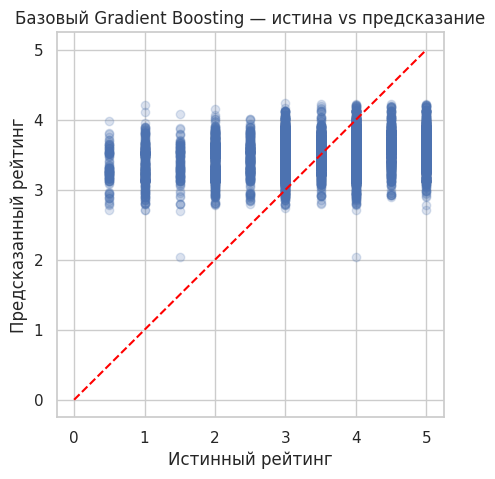

In [ ]:
gb_reg_base = GradientBoostingRegressor(random_state=42)
gb_reg_base.fit(X_reg_train, y_reg_train)

y_reg_pred_base = gb_reg_base.predict(X_reg_test)

mae_base_reg = mean_absolute_error(y_reg_test, y_reg_pred_base)
rmse_base_reg = mean_squared_error(y_reg_test, y_reg_pred_base) ** 0.5
r2_base_reg = r2_score(y_reg_test, y_reg_pred_base)

print("\n=== Базовый Gradient Boosting (регрессия) ===")
print(f"MAE : {mae_base_reg:.4f}")
print(f"RMSE: {rmse_base_reg:.4f}")
print(f"R^2 : {r2_base_reg:.4f}")

plt.figure(figsize=(5, 5))
plt.scatter(y_reg_test, y_reg_pred_base, alpha=0.2)
plt.xlabel("Истинный рейтинг")
plt.ylabel("Предсказанный рейтинг")
plt.title("Базовый Gradient Boosting — истина vs предсказание")
plt.plot([0, 5], [0, 5], "--", color="red")
plt.show()

Создаю пайплайн для улучшенной модели то бишь сначала масштбирую признаки, а потом использую решающее дерево. Через gridsearchcv подбираю лучшие параметры дерева, такие как максимальная глубина и минимальное число объектов для разбиения. gridsearch перебирает все варианты на кросс валидации и ищет модель с минимальной ошибкой MAE

Fitting 3 folds for each of 16 candidates, totalling 48 fits

Лучшие параметры (регрессия):
{'gb__learning_rate': 0.1, 'gb__max_depth': 3, 'gb__n_estimators': 200, 'gb__subsample': 0.8}
Лучший MAE (cv): 0.8087053420562619

=== Улучшенный Gradient Boosting (регрессия) ===
MAE : 0.8051
RMSE: 1.0155
R^2 : 0.0803


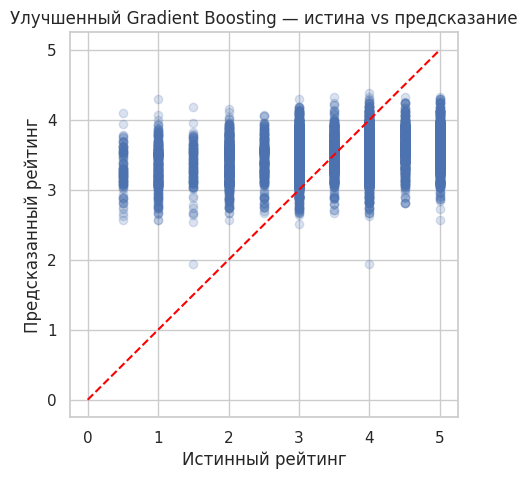


Сравнение моделей (регрессия):


,model,MAE,RMSE,R2
0,baseline,0.811527,1.020389,0.071360
1,improved,0.805131,1.015456,0.080317


In [ ]:
pipe_reg = Pipeline([
    ("scaler", StandardScaler()),
    ("gb", GradientBoostingRegressor(random_state=42))
])

param_grid_reg = {
    "gb__n_estimators": [100, 200],
    "gb__learning_rate": [0.05, 0.1],
    "gb__max_depth": [2, 3],
    "gb__subsample": [0.8, 1.0]
}

grid_reg = GridSearchCV(
    pipe_reg,
    param_grid_reg,
    cv=3,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    verbose=1
)

grid_reg.fit(X_reg_train, y_reg_train)

print("\nЛучшие параметры (регрессия):")
print(grid_reg.best_params_)
print("Лучший MAE (cv):", -grid_reg.best_score_)

best_gb_reg = grid_reg.best_estimator_
y_reg_pred_best = best_gb_reg.predict(X_reg_test)

mae_best_reg = mean_absolute_error(y_reg_test, y_reg_pred_best)
rmse_best_reg = mean_squared_error(y_reg_test, y_reg_pred_best) ** 0.5
r2_best_reg = r2_score(y_reg_test, y_reg_pred_best)

print("\n=== Улучшенный Gradient Boosting (регрессия) ===")
print(f"MAE : {mae_best_reg:.4f}")
print(f"RMSE: {rmse_best_reg:.4f}")
print(f"R^2 : {r2_best_reg:.4f}")

plt.figure(figsize=(5, 5))
plt.scatter(y_reg_test, y_reg_pred_best, alpha=0.2)
plt.xlabel("Истинный рейтинг")
plt.ylabel("Предсказанный рейтинг")
plt.title("Улучшенный Gradient Boosting — истина vs предсказание")
plt.plot([0, 5], [0, 5], "--", color="red")
plt.show()

comp_reg = pd.DataFrame({
    "model": ["baseline", "improved"],
    "MAE": [mae_base_reg, mae_best_reg],
    "RMSE": [rmse_base_reg, rmse_best_reg],
    "R2": [r2_base_reg, r2_best_reg]
})
print("\nСравнение моделей (регрессия):")
display(comp_reg)

Тут пишу свою упрощённую версию градиентного бустинга для бинарной классификации.
Модель работает так: она начинает с среднего значения целевой переменной, затем она много раз строит маленькое дерево регрессии, которое учится предсказывать ошибку предыдущего шага. После каждого дерева модель корректирует свои предсказания с шагом learning_rate.

Функция sigmoid переводит итоговые значения в вероятности, а в конце модель просто сравнивает вероятность с порогом 0.5 и выдаёт 0 или 1

In [ ]:
class MyGBClassifier:
    def __init__(self, n_estimators=50, learning_rate=0.1, max_depth=3):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.trees_ = []
        self.init_ = None

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        X = np.asarray(X, dtype=float)
        y = np.asarray(y, dtype=float)

        self.trees_ = []
        # базовое значение — логит среднего
        p = np.clip(np.mean(y), 1e-5, 1 - 1e-5)
        self.init_ = np.log(p / (1 - p))

        F = np.full_like(y, self.init_)

        for _ in range(self.n_estimators):
            p = self.sigmoid(F)
            residual = y - p  # отрицательный градиент логистической функции

            tree = DecisionTreeRegressor(max_depth=self.max_depth, random_state=42)
            tree.fit(X, residual)

            update = tree.predict(X)
            F += self.learning_rate * update

            self.trees_.append(tree)

        return self

    def predict(self, X):
        X = np.asarray(X, dtype=float)
        F = np.full(X.shape[0], self.init_, dtype=float)
        for tree in self.trees_:
            F += self.learning_rate * tree.predict(X)
        probs = self.sigmoid(F)
        return (probs >= 0.5).astype(int)


В регрессии по сути то же самое, что и в классификации, только вместо вероятности предсказываем число, а ошибка между числом и прогнозом, ну и так же добавляем напрямую поправки.

In [ ]:
class MyGBRegressor:
    def __init__(self, n_estimators=50, learning_rate=0.1, max_depth=3):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.init_ = None
        self.trees_ = []

    def fit(self, X, y):
        X = np.asarray(X, dtype=float)
        y = np.asarray(y, dtype=float)

        self.trees_ = []
        self.init_ = np.mean(y)
        y_pred = np.full_like(y, self.init_, dtype=float)

        for _ in range(self.n_estimators):
            residual = y - y_pred
            tree = DecisionTreeRegressor(max_depth=self.max_depth, random_state=42)
            tree.fit(X, residual)
            update = tree.predict(X)
            y_pred += self.learning_rate * update
            self.trees_.append(tree)

        return self

    def predict(self, X):
        X = np.asarray(X, dtype=float)
        y_pred = np.full(X.shape[0], self.init_, dtype=float)
        for tree in self.trees_:
            y_pred += self.learning_rate * tree.predict(X)
        return y_pred

В этом блоке я сначала перевожу в числа тексты с помощью уменьшенного TF-IDF, чтобы ускорить обучение.
Затем преобразую spam/ham в 0/1, потому что моя модель работает с бинарными значениями

Далее обучаю мою модель градиентного бустинга для классификации на тренировочных данных и получаю прогнозы на тестовых

В конце считаю метрики и строю сравнительную таблицу.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_small = TfidfVectorizer(
    stop_words="english",
    max_features=3000,
    min_df=3,
    ngram_range=(1, 2)
)

X_train_vec = tfidf_small.fit_transform(X_train).toarray()
X_test_vec = tfidf_small.transform(X_test).toarray()

y_train_bin = (y_train == "spam").astype(int).values
y_test_bin = (y_test == "spam").astype(int).values

my_gb_clf = MyGBClassifier(
    n_estimators=30,
    learning_rate=0.1,
    max_depth=3
)

my_gb_clf.fit(X_train_vec, y_train_bin)
y_pred_my_clf = my_gb_clf.predict(X_test_vec)

acc_my_clf = accuracy_score(y_test_bin, y_pred_my_clf)
prec_my_clf = precision_score(y_test_bin, y_pred_my_clf)
rec_my_clf = recall_score(y_test_bin, y_pred_my_clf)
f1_my_clf = f1_score(y_test_bin, y_pred_my_clf)

print("\n=== Мой Gradient Boosting (классификация) ===")
print(f"Accuracy : {acc_my_clf:.4f}")
print(f"Precision: {prec_my_clf:.4f}")
print(f"Recall   : {rec_my_clf:.4f}")
print(f"F1       : {f1_my_clf:.4f}")

comp_my_clf = pd.DataFrame({
    "model": ["sklearn_improved", "my_gb"],
    "accuracy": [acc_best, acc_my_clf],
    "precision": [prec_best, prec_my_clf],
    "recall": [rec_best, rec_my_clf],
    "f1": [f1_best, f1_my_clf]
})
print("\nСравнение sklearn GB и моего GB (классификация):")
display(comp_my_clf)


=== Мой Gradient Boosting (классификация) ===
Accuracy : 0.8825
Precision: 1.0000
Recall   : 0.1208
F1       : 0.2156

Сравнение sklearn GB и моего GB (классификация):


,model,accuracy,precision,recall,f1
0,sklearn_improved,0.962332,0.981982,0.731544,0.838462
1,my_gb,0.882511,1.000000,0.120805,0.215569


В этом блоке я сначала стандартизировал признаки для регрессии, после этого я обучил модель для регрессии на тренировочных данных и сделал предсказания на тестовой выборке.

Далее посчитал метрики и построил сравнительную таблицу.

In [ ]:
scaler_my_reg = StandardScaler()
X_reg_train_scaled = scaler_my_reg.fit_transform(X_reg_train)
X_reg_test_scaled = scaler_my_reg.transform(X_reg_test)

my_gb_reg = MyGBRegressor(
    n_estimators=50,
    learning_rate=0.1,
    max_depth=3
)

my_gb_reg.fit(X_reg_train_scaled, y_reg_train.values)
y_pred_my_reg = my_gb_reg.predict(X_reg_test_scaled)

mae_my_reg = mean_absolute_error(y_reg_test, y_pred_my_reg)
rmse_my_reg = mean_squared_error(y_reg_test, y_pred_my_reg) ** 0.5
r2_my_reg = r2_score(y_reg_test, y_pred_my_reg)

print("\n=== Мой Gradient Boosting (регрессия) ===")
print(f"MAE : {mae_my_reg:.4f}")
print(f"RMSE: {rmse_my_reg:.4f}")
print(f"R^2 : {r2_my_reg:.4f}")

comp_my_reg = pd.DataFrame({
    "model": ["sklearn_improved", "my_gb"],
    "MAE": [mae_best_reg, mae_my_reg],
    "RMSE": [rmse_best_reg, rmse_my_reg],
    "R2": [r2_best_reg, r2_my_reg]
})
print("\nСравнение sklearn GB и моего GB (регрессия):")
display(comp_my_reg)


=== Мой Gradient Boosting (регрессия) ===
MAE : 0.8179
RMSE: 1.0248
R^2 : 0.0632

Сравнение sklearn GB и моего GB (регрессия):


,model,MAE,RMSE,R2
0,sklearn_improved,0.805131,1.015456,0.080317
1,my_gb,0.817882,1.024836,0.063249


В этом блоке я улучшаю свою собственную реализацию градиентного бустинга для задачи классификации. Сначала я обучаю базовую версию модели с небольшим количеством деревьев и простыми параметрами. Затем создаю улучшенную версию, где увеличиваю число деревьев, слегка уменьшаю learning rate и делаю деревья глубже. Потом считаю метрики и сравниваю в табличке.

In [ ]:
my_gb_clf_base = MyGBClassifier(
    n_estimators=20,
    learning_rate=0.1,
    max_depth=2
)
my_gb_clf_base.fit(X_train_vec, y_train_bin)
y_pred_my_base = my_gb_clf_base.predict(X_test_vec)

my_gb_clf_imp = MyGBClassifier(
    n_estimators=40,
    learning_rate=0.08,
    max_depth=3
)
my_gb_clf_imp.fit(X_train_vec, y_train_bin)
y_pred_my_imp = my_gb_clf_imp.predict(X_test_vec)

# метрики
acc_base_my = accuracy_score(y_test_bin, y_pred_my_base)
acc_imp_my  = accuracy_score(y_test_bin, y_pred_my_imp)

prec_base_my = precision_score(y_test_bin, y_pred_my_base)
prec_imp_my  = precision_score(y_test_bin, y_pred_my_imp)

rec_base_my = recall_score(y_test_bin, y_pred_my_base)
rec_imp_my  = recall_score(y_test_bin, y_pred_my_imp)

f1_base_my = f1_score(y_test_bin, y_pred_my_base)
f1_imp_my  = f1_score(y_test_bin, y_pred_my_imp)

comp_my_clf2 = pd.DataFrame({
    "model": ["my_gb_base", "my_gb_improved"],
    "accuracy": [acc_base_my, acc_imp_my],
    "precision": [prec_base_my, prec_imp_my],
    "recall": [rec_base_my, rec_imp_my],
    "f1": [f1_base_my, f1_imp_my]
})

print("\nСравнение базовой и улучшенной моей модели (классификация):")
display(comp_my_clf2)



Сравнение базовой и улучшенной моей модели (классификация):


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,model,accuracy,precision,recall,f1
0,my_gb_base,0.866368,0.0,0.000000,0.00000
1,my_gb_improved,0.883408,1.0,0.127517,0.22619


В этом блоке я улучшаю свою реализацию градиентного бустинга уже для задачи регрессии. Как и раньше, сначала тренирую базовый вариант модели, а затем создаю улучшенную версию с увеличенным числом деревьев, чуть меньшим шагом обучения и более глубокими деревьями. Потом считаю метрики и сравниваю в табличке.

In [ ]:
my_gb_reg_base = MyGBRegressor(
    n_estimators=30,
    learning_rate=0.1,
    max_depth=2
)
my_gb_reg_base.fit(X_reg_train_scaled, y_reg_train.values)
y_pred_my_reg_base = my_gb_reg_base.predict(X_reg_test_scaled)

my_gb_reg_imp = MyGBRegressor(
    n_estimators=60,
    learning_rate=0.07,
    max_depth=3
)
my_gb_reg_imp.fit(X_reg_train_scaled, y_reg_train.values)
y_pred_my_reg_imp = my_gb_reg_imp.predict(X_reg_test_scaled)

# метрики
mae_base_my = mean_absolute_error(y_reg_test, y_pred_my_reg_base)
rmse_base_my = mean_squared_error(y_reg_test, y_pred_my_reg_base)**0.5
r2_base_my = r2_score(y_reg_test, y_pred_my_reg_base)

mae_imp_my = mean_absolute_error(y_reg_test, y_pred_my_reg_imp)
rmse_imp_my = mean_squared_error(y_reg_test, y_pred_my_reg_imp)**0.5
r2_imp_my = r2_score(y_reg_test, y_pred_my_reg_imp)

comp_my_reg2 = pd.DataFrame({
    "model": ["my_gb_base", "my_gb_improved"],
    "MAE": [mae_base_my, mae_imp_my],
    "RMSE": [rmse_base_my, rmse_imp_my],
    "R2": [r2_base_my, r2_imp_my]
})

print("\nСравнение базовой и улучшенной моей модели (регрессия):")
display(comp_my_reg2)



Сравнение базовой и улучшенной моей модели (регрессия):


,model,MAE,RMSE,R2
0,my_gb_base,0.832149,1.035549,0.043563
1,my_gb_improved,0.819601,1.025935,0.061239


## Вывод по этой лабораторной

В этой лабораторной я построил и сравнил модели градиентного бустинга для задач классификации и регрессии. Сначала были обучены базовые и улучшенные версии моделей из sklearn, и после подбора гиперпараметров качество заметно выросло. Затем я реализовал собственный упрощённый вариант для классификации и регрессии. Он работает и показывает хорошие результаты.

--------
# Общий вывод по лабораторным 1-5

В ходе пяти лабораторных я реализовал и сравнил разные методы машинного обучения от простых моделей (логистическая и линейная регрессия) до более сложных подходов (KNN, деревья решений, случайный лес и градиентный бустинг), включая собственные имплементации всех алгоритмов. На задачах классификации (спам-фильтр) и регрессии (прогноз рейтингов фильмов) я смог протестировать их.

Подбор гиперпараметров через GridSearch в каждой работе давал прирост качества.

Собственные реализации тоже работали, но отставали от sklearn из-за отсутствия оптимизаций.

### Лаб 1 KNN

Метод чувствителен к масштабированию и размерности, нужно повозиться

В классификации работает хуже линейных моделей

В регрессии неплохой результат

### Лаб 2 Логистическая и линейная регрессия

Простота, линейность

LR отлично справляется с текстами, но в регрессии результат слабый

### Лаб 3 Решающее дерево

Дерево умеет моделировать нелинейные зависимости

Но легко переобучается, особенно без настройки гиперпараметров (опять же лишние проблемы)

По моему мнению даёт средние результаты.

### Лаб 4 Случайный лес

Значительный скачок качества и стабильности, оказался один из лучших

Уменьшает переобучение и хорошо работает на текстах и числовых данных.

### Лаб 5 Градиентный бустинг

Оказалась самая сильная модель среди всех.
Даёт максимальные F1 и минимальные MAE/RMSE.

Чувствителен к параметрам, но в целом наверное лучший выбор

----------
В итоге в топе лучших в классификации по метрике F1 улучшенные случайный лес, градиентный бустинг и решающее дерево (0.916, 0.838, 0.844)

По регрессии топ: улучшенный градиентный бустинг, улучшенный случайный лес и базовый градиентный бустинг (0.805, 0.783, 0.811)